In [1]:
!export PATH=/Library/TeX/texbin:$PATH

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
from nltk.corpus import wordnet
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

In [3]:
import nltk

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yiyicusack/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yiyicusack/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yiyicusack/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**I. Part One: Basic Cleaning;**

**II. Part Two: NLP Preprocessing;**

**III. Part Three: NLP Model Training;**

**IV. Part Four: Analysis (word clouds and ABSA)**

**I. Part One: Basic Cleaning. This step including combining and renaming some columns, dropping null values.**

In [9]:
df = pd.read_csv('tweetsapplegoogle.csv', encoding='ISO-8859-1')
df.rename(columns={
    'tweet_text': 'Tweet Text',
    'emotion_in_tweet_is_directed_at': 'Target Brand or Product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion Type'
}, inplace=True)
df['Target Brand or Product'] = df['Target Brand or Product'].replace('iPad or iPhone App', 'Apple App')

categories_to_combine = ['Android', 'Android App']
df['Target Brand or Product'] = df['Target Brand or Product'].replace(categories_to_combine, 'Android and Android App')

categories_to_combine = ['Apple App', 'Other Apple product or service']
df['Target Brand or Product'] = df['Target Brand or Product'].replace(categories_to_combine, 'Apple App and other product/service')

df['Target Brand or Product'] = df['Target Brand or Product'].replace('Other Google product or service', 'Google App and other product/service')

df = df.dropna(subset=['Tweet Text'])

df['Emotion Type'] = df['Emotion Type'].replace({
    'No emotion toward brand or product': 'Neutral',
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative'
})

df = df[df['Emotion Type'] != "I can't tell"]
pd.set_option('display.max_colwidth', None)

df.to_csv('tweet_df_basic_cleaning.csv', index=False)

**The end of part one, basic cleaning is finished and we got 'tweet_df_basic_cleaning.csv' as the result dataframe.**

**II. Part Two: NLP Preprocessing**

**Step 1: Define X and y, perform a train-test-split**

In [10]:
X = df['Tweet Text']
y = df['Emotion Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

**Step 2: NLP Preprocessing**

**1. URL Removal:** Uses a regular expression to find and remove URLs (anything starting with http followed by non-space characters);

**2. Mention Removal:** Uses a regular expression to remove mentions (text starting with @ followed by word characters);

**3. Tokenization:** Breaks the text into individual words or tokens using a regular expression tokenizer;

**4. Lowercasing;** 

**5. Handling Negations:** Specifically looks for negation words (like "not", "no", etc.) and merges them with the subsequent word. This approach is particularly useful in sentiment analysis as it maintains the context of negation;

**6. Stopword Removal:** Filters out stopwords (common words that usually don't carry much meaning) from the text. Notably, typical negation words are excluded from the stopword list to ensure they are preserved in the text;

**7. Part-of-Speech Tagging:** Assigns parts of speech to each word (like noun, verb, adjective, etc.), which is necessary for the next step, lemmatization;

**8. Lemmatization:** Reduces words to their base or dictionary form (lemmas). This is done in a context-sensitive way, based on the part-of-speech of each word;

**9. Aggregating Processed Words:** Joins the processed words back into a single string, making it suitable for vectorization or direct input into a machine learning model;

In [14]:
negation_words = {'no', 'not', 'nor', 'none', 'never', 'nobody', 'nothing', 'neither', 'nowhere', 'hardly', 'scarcely', 'barely'}
sw = set(stopwords.words('english')) - negation_words

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer() 

def doc_preparer(doc, stop_words=sw):
    doc = re.sub(r'http\S+', '', doc)
    doc = re.sub(r'@\w+', '', doc)
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokens = regex_token.tokenize(doc)
    lowered_tokens = [word.lower() for word in tokens]
    tokens_with_negations_handled = []
    i = 0
    while i < len(lowered_tokens):
        if lowered_tokens[i] in negation_words and i+1 < len(lowered_tokens):
            tokens_with_negations_handled.append(lowered_tokens[i] + '_' + lowered_tokens[i+1])
            i += 2
        else:
            tokens_with_negations_handled.append(lowered_tokens[i])
            i += 1
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag([word])[0][1])) for word in tokens_with_negations_handled if word not in stop_words])

token_docs = X_train.apply(doc_preparer)

**Step 3: Secondary train-test split to build the best models; try Count Vectorizer first**

In [16]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

**Now we have the new training set: X_t, y_t; our validation set: X_val, y_val**

**III. Part Three: NLP Model Training;**

**How can we improve the performance?**

**1. Model Tuning:** We can try to fine-tune the parameters of the models;

**2. Feature Engineering:** We can experiment with different tokenization strategies, using n-grams or TF-IDF vectorization;

**3. Alternative Resampling Techniques:** We can try KMeansSMOTE or data augmentation (synonyms);

**4. Different Models:** Naive Bayes, Random Forests, Gradient Boosting, or more advanced models;

**5. Class Weights:** If it works for some models. Note: It does not work for Naive Bayes.

**1. Model One: Using Naive Bayes as Classifier**

**Challenge 1:** In scikit-learn's implementation of Naive Bayes classifiers, such as MultinomialNB, there is no direct support for the class_weight parameter. This is primarily due to the nature of how Naive Bayes works, which is fundamentally different from algorithms like Logistic Regression or Support Vector Machines where class weights can be directly applied to the cost function.

Naive Bayes classifiers work based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of features. The algorithm computes the likelihood of the features given a particular class and then applies Bayes' theorem to compute the posterior probability. **Because of this probabilistic foundation and the way Naive Bayes calculates probabilities, it doesn't have a straightforward way to incorporate class weights into this process.**

**Without any resampling technique, how will the model perform?**

In [140]:
label_encoder = LabelEncoder()
y_t_encoded = label_encoder.fit_transform(y_t)
y_val_encoded = label_encoder.transform(y_val)

nb_model = MultinomialNB()
nb_model.fit(X_t_vec, y_t_encoded)

y_pred = nb_model.predict(X_val_vec)

accuracy = accuracy_score(y_val_encoded, y_pred)
precision = precision_score(y_val_encoded, y_pred, average='weighted')  # Use 'weighted' for imbalanced classes
recall = recall_score(y_val_encoded, y_pred, average='weighted')
f1 = f1_score(y_val_encoded, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.655727923627685
Precision: 0.6449473536055461
Recall: 0.655727923627685
F1 Score: 0.6385126547517754


In [141]:
nb_model = MultinomialNB()

scoring_metrics = {'accuracy': 'accuracy', 
                   'precision_macro': 'precision_macro', 
                   'recall_macro': 'recall_macro', 
                   'f1_macro': 'f1_macro'}

cv_results = cross_validate(nb_model, X_t_vec, y_t_encoded, cv=5, scoring=scoring_metrics)

for metric in scoring_metrics.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()} scores for each fold:", scores)
    print(f"Average {metric}: {np.mean(scores)}\n")

Accuracy scores for each fold: [0.63518887 0.66268657 0.65074627 0.64378109 0.66567164]
Average accuracy: 0.6516148877877017

Precision_macro scores for each fold: [0.53859509 0.55329299 0.5610319  0.51467383 0.58878283]
Average precision_macro: 0.5512753280382555

Recall_macro scores for each fold: [0.47924349 0.48153969 0.49440611 0.46825877 0.51151646]
Average recall_macro: 0.4869929019739564

F1_macro scores for each fold: [0.49311541 0.49533034 0.51034683 0.47957422 0.53206773]
Average f1_macro: 0.5020869048193782



In [142]:
report = classification_report(y_val_encoded, y_pred, target_names=label_encoder.classes_)

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.56      0.09      0.16        98
     Neutral       0.70      0.79      0.74      1004
    Positive       0.56      0.51      0.54       574

    accuracy                           0.66      1676
   macro avg       0.61      0.47      0.48      1676
weighted avg       0.64      0.66      0.64      1676



**The recall(0.09) and f1-score(0.16) for Negative is very bad, as expected.** 

Let's try **KMeans SMOTE** and **data augmentation (synonym replacement)**

In [143]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
X_t_resampled, y_t_resampled = kmeans_smote.fit_resample(X_t_vec.values, y_t)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_t_resampled, y_t_resampled)

MultinomialNB()

In [144]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
reports = []

for train_index, test_index in skf.split(X_t_vec, y_t):
    X_train_fold, X_test_fold = X_t_vec.iloc[train_index], X_t_vec.iloc[test_index]
    y_train_fold, y_test_fold = y_t.iloc[train_index], y_t.iloc[test_index]

    # Convert DataFrame to Sparse Matrix
    X_train_fold_sparse = csr_matrix(X_train_fold)

    kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
    X_train_fold_resampled, y_train_fold_resampled = kmeans_smote.fit_resample(X_train_fold_sparse, y_train_fold)

    # Convert the resampled data back to DataFrame
    X_train_fold_resampled = pd.DataFrame(X_train_fold_resampled.toarray(), columns=X_t_vec.columns)

    classifier = MultinomialNB()
    classifier.fit(X_train_fold_resampled, y_train_fold_resampled)

    y_pred_fold = classifier.predict(X_test_fold)
    accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
    reports.append(classification_report(y_test_fold, y_pred_fold))

print("Average Accuracy:", np.mean(accuracies))
for i, report in enumerate(reports):
    print(f"\nClassification Report for fold {i + 1}:\n{report}")

Average Accuracy: 0.6195796366082115

Classification Report for fold 1:
              precision    recall  f1-score   support

    Negative       0.15      0.19      0.17        63
     Neutral       0.75      0.66      0.70       606
    Positive       0.52      0.61      0.56       337

    accuracy                           0.61      1006
   macro avg       0.47      0.49      0.48      1006
weighted avg       0.64      0.61      0.62      1006


Classification Report for fold 2:
              precision    recall  f1-score   support

    Negative       0.29      0.35      0.31        63
     Neutral       0.74      0.69      0.72       605
    Positive       0.54      0.58      0.56       337

    accuracy                           0.63      1005
   macro avg       0.52      0.54      0.53      1005
weighted avg       0.65      0.63      0.64      1005


Classification Report for fold 3:
              precision    recall  f1-score   support

    Negative       0.25      0.33      0.

In [145]:
y_pred = nb_classifier.predict(X_val_vec)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.6264916467780429

Classification Report:
               precision    recall  f1-score   support

    Negative       0.31      0.32      0.31        98
     Neutral       0.74      0.66      0.70      1004
    Positive       0.52      0.63      0.57       574

    accuracy                           0.63      1676
   macro avg       0.53      0.53      0.53      1676
weighted avg       0.64      0.63      0.63      1676



/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


**We can see that the recall(0.32) and f1-score(0.31) have been improved significantly.**

**Try TF-IDF and see if it brings better result than CountVectorizer**

In [148]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

X_t_vec_tf = tfidf_vectorizer.fit_transform(X_t)
X_t_vec_tf = pd.DataFrame.sparse.from_spmatrix(X_t_vec_tf)
X_t_vec_tf.columns = sorted(tfidf_vectorizer.vocabulary_)
X_t_vec_tf.set_index(y_t.index, inplace=True)

X_val_vec_tf = tfidf_vectorizer.transform(X_val)
X_val_vec_tf = pd.DataFrame.sparse.from_spmatrix(X_val_vec_tf)
X_val_vec_tf.columns = sorted(tfidf_vectorizer.vocabulary_)
X_val_vec_tf.set_index(y_val.index, inplace=True)

kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
X_t_resampled_tf, y_t_resampled_tf = kmeans_smote.fit_resample(X_t_vec_tf.values, y_t)

nb_classifier_tf = MultinomialNB()
nb_classifier_tf.fit(X_t_resampled_tf, y_t_resampled_tf)

MultinomialNB()

**Perform cross validation to see how well the TF-IDF, KMeans with Naive Bayes model turns out**

In [150]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
reports = []

for train_index, test_index in skf.split(X_t_vec_tf, y_t):
    X_train_fold, X_test_fold = X_t_vec_tf.iloc[train_index], X_t_vec_tf.iloc[test_index]
    y_train_fold, y_test_fold = y_t.iloc[train_index], y_t.iloc[test_index]

    # Convert DataFrame to Sparse Matrix
    X_train_fold_sparse = csr_matrix(X_train_fold)

    kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
    X_train_fold_resampled, y_train_fold_resampled = kmeans_smote.fit_resample(X_train_fold_sparse, y_train_fold)

    # Convert the resampled data back to DataFrame
    X_train_fold_resampled = pd.DataFrame(X_train_fold_resampled.toarray(), columns=X_t_vec_tf.columns)

    classifier = MultinomialNB()
    classifier.fit(X_train_fold_resampled, y_train_fold_resampled)

    y_pred_fold = classifier.predict(X_test_fold)
    accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
    reports.append(classification_report(y_test_fold, y_pred_fold))

print("Average Accuracy:", np.mean(accuracies))
for i, report in enumerate(reports):
    print(f"\nClassification Report for fold {i + 1}:\n{report}")

Average Accuracy: 0.5775992799422371

Classification Report for fold 1:
              precision    recall  f1-score   support

    Negative       0.16      0.33      0.21        63
     Neutral       0.72      0.57      0.64       606
    Positive       0.50      0.59      0.54       337

    accuracy                           0.56      1006
   macro avg       0.46      0.50      0.47      1006
weighted avg       0.62      0.56      0.58      1006


Classification Report for fold 2:
              precision    recall  f1-score   support

    Negative       0.25      0.40      0.30        63
     Neutral       0.73      0.61      0.66       605
    Positive       0.50      0.59      0.54       337

    accuracy                           0.59      1005
   macro avg       0.49      0.53      0.50      1005
weighted avg       0.62      0.59      0.60      1005


Classification Report for fold 3:
              precision    recall  f1-score   support

    Negative       0.22      0.32      0.

**Not too well, slightly worse than CountVectorizer**

**Try Data Augmentation Function:** This function will take a sentence and replace some of its words with synonyms.

In [93]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def augment_sentence(sentence, n_augmentations=1):
    words = nltk.word_tokenize(sentence)
    augmented_sentences = [sentence]
    
    for _ in range(n_augmentations):
        new_words = words.copy()
        random_word_list = list(set([word for word in words if word.isalpha()]))
        random.shuffle(random_word_list)
        
        num_replaced = 0
        for random_word in random_word_list:
            synonyms = get_synonyms(random_word)
            if len(synonyms) > 0:
                synonym = random.choice(synonyms)
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1

        if num_replaced > 0:
            augmented_sentences.append(' '.join(new_words))

    return augmented_sentences

label_encoder = LabelEncoder()

# Fit the label encoder on the target variable
label_encoder.fit(y_train)

encoded_y_train = label_encoder.transform(y_train)

encoded_y_train_series = pd.Series(encoded_y_train)

# Split your data into training and validation sets
X_t, X_val, y_t, y_val = train_test_split(token_docs, encoded_y_train_series,
                                          test_size=0.25, random_state=42)

# Create a list to store augmented data
augmented_X_t = []
augmented_encoded_y_t = []

for text, label in zip(X_t, y_t):
    if label == label_encoder.transform(['Negative']):
        augmented_texts = augment_sentence(text, n_augmentations=2)
        num_augmented = len(augmented_texts)
        augmented_X_t.extend(augmented_texts)
        augmented_encoded_y_t.extend([label] * num_augmented)
    else:
        augmented_X_t.append(text)
        augmented_encoded_y_t.append(label)

cv = CountVectorizer()

X_t_vec = cv.fit_transform(augmented_X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)

# Transform the validation data
X_val_vec = cv.transform(X_val)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)

# Set the index of the validation data DataFrame to match the validation data
X_val_vec.index = y_val.index

In [94]:
X_t_vec_dense = X_t_vec.to_numpy()
X_val_vec_dense = X_val_vec.to_numpy()

nb_model = MultinomialNB()
nb_model.fit(X_t_vec_dense, augmented_encoded_y_t)
y_pred_encoded = nb_model.predict(X_val_vec_dense)

y_pred = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_val, y_pred)
accuracy

0.0

**Apparantly something went wrong here, this part needs further examination**

**Let's use Random Forest and see if it performs better?**

In [118]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_t_resampled, y_t_resampled)

RandomForestClassifier(random_state=42)

In [119]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
reports = []

for train_index, test_index in skf.split(X_t_vec, y_t):
    X_train_fold, X_test_fold = X_t_vec.iloc[train_index], X_t_vec.iloc[test_index]
    y_train_fold, y_test_fold = y_t.iloc[train_index], y_t.iloc[test_index]

    # Convert DataFrame to Sparse Matrix
    X_train_fold_sparse = csr_matrix(X_train_fold)

    kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
    X_train_fold_resampled, y_train_fold_resampled = kmeans_smote.fit_resample(X_train_fold_sparse, y_train_fold)

    # Convert the resampled data back to DataFrame
    X_train_fold_resampled = pd.DataFrame(X_train_fold_resampled.toarray(), columns=X_t_vec.columns)

    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train_fold_resampled, y_train_fold_resampled)

    y_pred_fold = classifier.predict(X_test_fold)
    accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
    reports.append(classification_report(y_test_fold, y_pred_fold))

print("Average Accuracy:", np.mean(accuracies))
for i, report in enumerate(reports):
    print(f"\nClassification Report for fold {i + 1}:\n{report}")

Average Accuracy: 0.6072385586975659

Classification Report for fold 1:
              precision    recall  f1-score   support

    Negative       0.23      0.35      0.28        63
     Neutral       0.73      0.72      0.73       606
    Positive       0.55      0.50      0.52       337

    accuracy                           0.63      1006
   macro avg       0.50      0.53      0.51      1006
weighted avg       0.64      0.63      0.63      1006


Classification Report for fold 2:
              precision    recall  f1-score   support

    Negative       0.22      0.37      0.27        63
     Neutral       0.73      0.66      0.69       605
    Positive       0.52      0.53      0.52       337

    accuracy                           0.60      1005
   macro avg       0.49      0.52      0.50      1005
weighted avg       0.62      0.60      0.61      1005


Classification Report for fold 3:
              precision    recall  f1-score   support

    Negative       0.23      0.32      0.

In [120]:
y_pred = rf_classifier.predict(X_val_vec)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.6282816229116945

Classification Report:
               precision    recall  f1-score   support

    Negative       0.25      0.32      0.28        98
     Neutral       0.75      0.67      0.71      1004
    Positive       0.53      0.61      0.57       574

    accuracy                           0.63      1676
   macro avg       0.51      0.53      0.52      1676
weighted avg       0.65      0.63      0.63      1676



/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


**Random Forest did not generate promising result; although, with some tuning, it might perform better.**

**Try SVM with TF-IDF and KMeansSMOTE**

In [12]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

X_t_vec_tf = tfidf_vectorizer.fit_transform(X_t)
X_t_vec_tf = pd.DataFrame.sparse.from_spmatrix(X_t_vec_tf)
X_t_vec_tf.columns = sorted(tfidf_vectorizer.vocabulary_)
X_t_vec_tf.set_index(y_t.index, inplace=True)


kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
X_t_resampled_tf, y_t_resampled_tf = kmeans_smote.fit_resample(X_t_vec_tf.values, y_t)

svm_classifier_tf = SVC(random_state=42)

svm_classifier_tf.fit(X_t_resampled_tf, y_t_resampled_tf)

X_val_vec_tf_transformed = tfidf_vectorizer.transform(X_val)
X_val_vec_tf_transformed = pd.DataFrame.sparse.from_spmatrix(X_val_vec_tf_transformed)
X_val_vec_tf_transformed.columns = sorted(tfidf_vectorizer.vocabulary_)
X_val_vec_tf_transformed.set_index(y_val.index, inplace=True)

X_val_vec_tf_dense = X_val_vec_tf_transformed.to_numpy()

y_pred_val = svm_classifier_tf.predict(X_val_vec_tf_dense)

print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 0.6879474940334129

Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      0.22      0.34        98
     Neutral       0.70      0.85      0.77      1004
    Positive       0.65      0.48      0.55       574

    accuracy                           0.69      1676
   macro avg       0.69      0.52      0.55      1676
weighted avg       0.68      0.69      0.67      1676



**SVM is the best base model so far**

**Try Feature Selection: the best result so far when it comes to traditional machine learning models**

In [27]:
from sklearn.feature_selection import SelectKBest, chi2

# Define the feature selection
feature_selection = SelectKBest(chi2, k=4000)  # Adjust k as needed

# Apply feature selection to training data
X_t_selected = feature_selection.fit_transform(X_t_resampled, y_t_resampled)

# Apply the same transformation to validation data
X_val_selected = feature_selection.transform(X_val_vec)

# Train SVM on selected features
svm_model.fit(X_t_selected, y_t_resampled)

# Predict on validation set
y_pred_val = svm_model.predict(X_val_selected)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

Accuracy: 0.6843675417661098

Classification Report:
               precision    recall  f1-score   support

    Negative       0.73      0.24      0.37        98
     Neutral       0.71      0.83      0.76      1004
    Positive       0.62      0.51      0.56       574

    accuracy                           0.68      1676
   macro avg       0.69      0.53      0.56      1676
weighted avg       0.68      0.68      0.67      1676



**Using GridSearchCV to find the best hyperparameters.**

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import KMeansSMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_t_vec = tfidf_vectorizer.fit_transform(X_t)
X_val_vec = tfidf_vectorizer.transform(X_val)

kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
X_t_resampled, y_t_resampled = kmeans_smote.fit_resample(X_t_vec, y_t)

svm_model = SVC(random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto'], 
    'kernel': ['linear', 'rbf', 'poly']
}
grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_t_resampled, y_t_resampled)

print("Best Parameters:", grid_search.best_params_)

best_estimator = grid_search.best_estimator_

y_pred_val = best_estimator.predict(X_val_vec)

print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.681980906921241

Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      0.22      0.34        98
     Neutral       0.71      0.82      0.76      1004
    Positive       0.62      0.51      0.56       574

    accuracy                           0.68      1676
   macro avg       0.68      0.52      0.55      1676
weighted avg       0.68      0.68      0.67      1676



**The result did not get improved significantly**

**Let's try using RandomizedSearchCV**

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Define the SVM Model
svm_model = SVC(random_state=42)

# Parameters for RandomizedSearchCV
param_distributions = {
    'C': reciprocal(0.1, 100), 
    'gamma': expon(scale=1.0), 
    'kernel': ['linear', 'rbf', 'poly']
}

# Randomized Search for Hyperparameter Tuning
random_search = RandomizedSearchCV(svm_model, param_distributions, n_iter=100, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_t_resampled, y_t_resampled)

# Printa best parameters
print("Best Parameters:", random_search.best_params_)

# Get the best estimator
best_estimator = random_search.best_estimator_

# Evaluate the Model
# Predict on the validation set
y_pred_val = best_estimator.predict(X_val_vec)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))


Best Parameters: {'C': 66.13027479748719, 'gamma': 3.636812255969223, 'kernel': 'rbf'}
Accuracy: 0.6348448687350835

Classification Report:
               precision    recall  f1-score   support

    Negative       0.65      0.17      0.27        98
     Neutral       0.64      0.91      0.75      1004
    Positive       0.61      0.23      0.33       574

    accuracy                           0.63      1676
   macro avg       0.63      0.44      0.45      1676
weighted avg       0.63      0.63      0.58      1676



**Still not very good**

**Ran into issues when I tried to utilize pipeline**

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Create a pipeline with TF-IDF vectorization, SMOTE, and SVM classifier
pipeline = make_pipeline_imb(
    TfidfVectorizer(),
    KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100),
    SVC(random_state=42)
)

# Define a grid of parameters to search over
param_grid = {
    'tfidfvectorizer__max_features': [5000, 10000, None], # None means use all features
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],      # Unigrams or bigrams
    'svc__C': [0.1, 1, 10],                               # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],                     # Type of SVM kernel
    # Add more parameters here if necessary
}

# Set up GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_t, y_t)

# Best parameter set
print("Best parameters found: ", grid_search.best_params_)

# Best estimator
best_estimator = grid_search.best_estimator_

# Predict on the validation set
y_pred_val = best_estimator.predict(X_val)

# Evaluate the best estimator on the validation set
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END svc__C=0.1, svc__kernel=linear, tfidfvectorizer__max_features=5000, tfidfvectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END svc__C=0.1, svc__kernel=linear, tfidfvectorizer__max_features=5000, tfidfvectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END svc__C=0.1, svc__kernel=linear, tfidfvectorizer__max_features=5000, tfidfvectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END svc__C=0.1, svc__kernel=linear, tfidfvectorizer__max_features=5000, tfidfvectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END svc__C=0.1, svc__kernel=linear, tfidfvectorizer__max_features=5000, tfidfvectorizer__ngram_range=(1, 1); total time=   0.0s
[CV] END svc__C=0.1, svc__kernel=linear, tfidfvectorizer__max_features=5000, tfidfvectorizer__ngram_range=(1, 2); total time=   0.0s
[CV] END svc__C=0.1, svc__kernel=linear, tfidfvectorizer__max_features=5000, tfidfvectorizer__ngram_range=(1, 2); total time=   0.0s
[CV] EN

ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/imblearn/pipeline.py", line 292, in fit
    fit_params_steps = self._check_fit_params(**fit_params)
AttributeError: 'Pipeline' object has no attribute '_check_fit_params'


**Let's perform a cross validation and see how it performs:**

In [158]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracies, precisions, recalls, f1s = [], [], [], []

# Ensure X_t_vec_tf is in the correct format (numpy array)
X_t_vec_tf_array = X_t_vec_tf.values

for train_index, test_index in skf.split(X_t_vec_tf_array, y_t):
    # Split data
    X_train_fold, X_test_fold = X_t_vec_tf_array[train_index], X_t_vec_tf_array[test_index]
    y_train_fold, y_test_fold = y_t.iloc[train_index], y_t.iloc[test_index]

    # Apply KMeansSMOTE
    kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
    X_train_fold_resampled, y_train_fold_resampled = kmeans_smote.fit_resample(X_train_fold, y_train_fold)

    # Train the classifier
    classifier = SVC(random_state=42)
    classifier.fit(X_train_fold_resampled, y_train_fold_resampled)

    # Predict on the test fold
    y_pred_fold = classifier.predict(X_test_fold)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test_fold, y_pred_fold))
    precisions.append(precision_score(y_test_fold, y_pred_fold, average='macro'))
    recalls.append(recall_score(y_test_fold, y_pred_fold, average='macro'))
    f1s.append(f1_score(y_test_fold, y_pred_fold, average='macro'))

# Print average scores
print("Average Accuracy:", np.mean(accuracies))
print("Average Precision:", np.mean(precisions))
print("Average Recall:", np.mean(recalls))
print("Average F1 Score:", np.mean(f1s))

Average Accuracy: 0.676082608824664
Average Precision: 0.6736755295746988
Average Recall: 0.47791150234469076
Average F1 Score: 0.5027426176325479


**Try SVM with TF-IDF and Class Weights**

In [155]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

X_t_vec_tf = tfidf_vectorizer.fit_transform(X_t)
X_t_vec_tf = pd.DataFrame.sparse.from_spmatrix(X_t_vec_tf)
X_t_vec_tf.columns = sorted(tfidf_vectorizer.vocabulary_)
X_t_vec_tf.set_index(y_t.index, inplace=True)

X_val_vec_tf_transformed = tfidf_vectorizer.transform(X_val)
X_val_vec_tf_transformed = pd.DataFrame.sparse.from_spmatrix(X_val_vec_tf_transformed)
X_val_vec_tf_transformed.columns = sorted(tfidf_vectorizer.vocabulary_)
X_val_vec_tf_transformed.set_index(y_val.index, inplace=True)

X_val_vec_tf_dense = X_val_vec_tf_transformed.to_numpy()
X_t_vec_tf_dense = X_t_vec_tf.to_numpy()

svm_classifier_balanced = SVC(random_state=42, class_weight='balanced')
svm_classifier_balanced.fit(X_t_vec_tf_dense, y_t)
y_pred_val = svm_classifier_balanced.predict(X_val_vec_tf_dense)

print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

Accuracy: 0.668854415274463

Classification Report:
               precision    recall  f1-score   support

    Negative       0.53      0.24      0.34        98
     Neutral       0.74      0.75      0.74      1004
    Positive       0.56      0.61      0.59       574

    accuracy                           0.67      1676
   macro avg       0.61      0.53      0.55      1676
weighted avg       0.67      0.67      0.66      1676



**Result: No better than SVM with TF-IDF and KMeansSMOTE**

In [162]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming token_docs and y_train are your data
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=0.25, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_t_vec = tfidf_vectorizer.fit_transform(X_t)
X_val_vec = tfidf_vectorizer.transform(X_val)

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
y_t_encoded = label_encoder.fit_transform(y_t)
y_val_encoded = label_encoder.transform(y_val)

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Train the classifier using encoded labels
xgb_classifier.fit(X_t_vec, y_t_encoded)

# Predict on the validation set
y_pred_encoded = xgb_classifier.predict(X_val_vec)

# Decode the predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.6640811455847255

Classification Report:
               precision    recall  f1-score   support

    Negative       0.32      0.07      0.12        98
     Neutral       0.69      0.85      0.76      1004
    Positive       0.61      0.44      0.51       574

    accuracy                           0.66      1676
   macro avg       0.54      0.45      0.46      1676
weighted avg       0.64      0.66      0.64      1676



**Trying XGBoost with KMeansSMOTE and TF-IDF**

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import KMeansSMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_t_vec = tfidf_vectorizer.fit_transform(X_t)
X_val_vec = tfidf_vectorizer.transform(X_val)

label_encoder = LabelEncoder()
y_t_encoded = label_encoder.fit_transform(y_t)
y_val_encoded = label_encoder.transform(y_val)

kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.01, kmeans_estimator=100)
X_t_resampled, y_t_resampled = kmeans_smote.fit_resample(X_t_vec, y_t_encoded)

xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_t_resampled, y_t_resampled)

y_pred_encoded = xgb_classifier.predict(X_val_vec)

y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.6599045346062052

Classification Report:
               precision    recall  f1-score   support

    Negative       0.32      0.10      0.16        98
     Neutral       0.69      0.84      0.75      1004
    Positive       0.61      0.45      0.52       574

    accuracy                           0.66      1676
   macro avg       0.54      0.46      0.47      1676
weighted avg       0.64      0.66      0.64      1676



**Pre-trained Deep Learning Models:**

**1. RoBERTa**

In [12]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from datasets import load_metric

df = pd.read_csv('tweet_df_basic_cleaning.csv')  # Update the path if necessary

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    return text

df['cleaned_text'] = df['Tweet Text'].apply(clean_text)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_encodings = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=512)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = TweetDataset(train_encodings, train_df['Emotion Type'].map(label_map).tolist())
val_dataset = TweetDataset(val_encodings, val_df['Emotion Type'].map(label_map).tolist())
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=512)
test_dataset = TweetDataset(test_encodings, test_df['Emotion Type'].map(label_map).tolist())

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   # Evaluation batch size (can be larger if you have enough memory)
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
)

accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }
    
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Provide the validation dataset here
    compute_metrics=compute_metrics
)


trainer.train()


predictions = trainer.predict(test_dataset)


true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)


report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))


print(report)


eval_results = trainer.evaluate(eval_dataset=val_dataset)


print("Validation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")


print("\nTest results:")
test_results = trainer.evaluate(eval_dataset=test_dataset)
for key, value in test_results.items():
    print(f"{key}: {value}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-

Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


              precision    recall  f1-score   support

    Negative       0.62      0.58      0.60        65
     Neutral       0.81      0.84      0.83       542
    Positive       0.71      0.68      0.69       287

    accuracy                           0.77       894
   macro avg       0.72      0.70      0.71       894
weighted avg       0.77      0.77      0.77       894



Validation results:
eval_loss: 0.5764042735099792
eval_accuracy: 0.7627329192546584
eval_precision: 0.7608432119688819
eval_recall: 0.7627329192546584
eval_f1: 0.7607871938398586
eval_runtime: 1.7615
eval_samples_per_second: 456.991
eval_steps_per_second: 7.38
epoch: 3.0

Test results:
eval_loss: 0.6266144514083862
eval_accuracy: 0.7695749440715883
eval_precision: 0.7670542308982925
eval_recall: 0.7695749440715883
eval_f1: 0.7679609984838811
eval_runtime: 2.1777
eval_samples_per_second: 410.525
eval_steps_per_second: 6.429
epoch: 3.0


**2. XLNet**

In [4]:
import torch
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments
from datasets import load_metric
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


df = pd.read_csv('tweet_df_basic_cleaning.csv')

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    return text

df['cleaned_text'] = df['Tweet Text'].apply(clean_text)
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)
train_encodings = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=512)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = TweetDataset(train_encodings, train_df['Emotion Type'].map(label_map).tolist())
val_dataset = TweetDataset(val_encodings, val_df['Emotion Type'].map(label_map).tolist())
test_dataset = TweetDataset(test_encodings, test_df['Emotion Type'].map(label_map).tolist())


model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)


training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    evaluation_strategy="epoch",     
    save_strategy="epoch",           
)


accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")


predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
conf_matrix = confusion_matrix(true_labels, predicted_labels)


print("\nConfusion Matrix:")
print(conf_matrix)


test_report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))
print("\nTest Classification Report:")
print(test_report)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/3075248869.py:73: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' ins

Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 0.6606034636497498
eval_accuracy: 0.7416149068322981
eval_precision: 0.7422190162654969
eval_recall: 0.7416149068322981
eval_f1: 0.7409106000624377
eval_runtime: 3.3338
eval_samples_per_second: 241.468
eval_steps_per_second: 3.899
epoch: 3.0

Confusion Matrix:
[[ 38  19   8]
 [ 17 449  76]
 [  3  92 192]]

Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.58      0.62        65
     Neutral       0.80      0.83      0.81       542
    Positive       0.70      0.67      0.68       287

    accuracy                           0.76       894
   macro avg       0.72      0.69      0.70       894
weighted avg       0.76      0.76      0.76       894



**3. BERTweet: the best model so far**

In [60]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

train_encodings = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_df['Emotion Type'].map(label_map).tolist())
val_dataset = TweetDataset(val_encodings, val_df['Emotion Type'].map(label_map).tolist())
test_dataset = TweetDataset(test_encodings, test_df['Emotion Type'].map(label_map).tolist())


model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=3)


training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    evaluation_strategy="epoch",     
    save_strategy="epoch",           
)


accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


trainer.train()


eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")


predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
conf_matrix = confusion_matrix(true_labels, predicted_labels)


print("\nConfusion Matrix:")
print(conf_matrix)


test_report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))
print("\nTest Classification Report:")
print(test_report)

train_df['labels'] = train_df['Emotion Type'].map(label_map)
encoded_input = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

skf = StratifiedKFold(n_splits=5)
fold_results = []

for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(len(train_df)), train_df['labels']), start=1):
    print(f"Training on Fold {fold}")
    
    train_encodings = {key: val[train_index] for key, val in encoded_input.items()}
    val_encodings = {key: val[val_index] for key, val in encoded_input.items()}
    train_labels, val_labels = train_df['labels'].iloc[train_index], train_df['labels'].iloc[val_index]

    train_dataset = TweetDataset(train_encodings, train_labels.tolist())
    val_dataset = TweetDataset(val_encodings, val_labels.tolist())

    model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=3)

    training_args = TrainingArguments(
        output_dir=f'./results/fold_{fold}',          
        num_train_epochs=3,              
        per_device_train_batch_size=16,  
        per_device_eval_batch_size=64,  
        warmup_steps=500,                
        weight_decay=0.01,               
        logging_dir=f'./logs/fold_{fold}',            
        evaluation_strategy="epoch",     
        save_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate(eval_dataset=val_dataset)
    fold_results.append(eval_results)
    print(f"Results for Fold {fold}: {eval_results}\n")

final_results = {metric: np.mean([result[metric] for result in fold_results]) for metric in fold_results[0]}
print("Average Results Across All Folds:")
for metric, value in final_results.items():
    print(f"{metric}: {value}")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from th

Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 0.6304669976234436
eval_accuracy: 0.7552795031055901
eval_precision: 0.7543404051245983
eval_recall: 0.7552795031055901
eval_f1: 0.752564579289859
eval_runtime: 1.6531
eval_samples_per_second: 486.959
eval_steps_per_second: 7.864
epoch: 3.0

Confusion Matrix:
[[ 38  19   8]
 [  9 459  74]
 [  5  80 202]]

Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.58      0.65        65
     Neutral       0.82      0.85      0.83       542
    Positive       0.71      0.70      0.71       287

    accuracy                           0.78       894
   macro avg       0.75      0.71      0.73       894
weighted avg       0.78      0.78      0.78       894

Training on Fold 1


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Checkpoint destination directory ./results/fold_1/checkpoint-362 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/fold_1/checkpoint-724 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.enc

Results for Fold 1: {'eval_loss': 0.6541054844856262, 'eval_accuracy': 0.7513812154696132, 'eval_precision': 0.7523628617065385, 'eval_recall': 0.7513812154696132, 'eval_f1': 0.7517739392208925, 'eval_runtime': 5.2683, 'eval_samples_per_second': 274.853, 'eval_steps_per_second': 4.366, 'epoch': 3.0}

Training on Fold 2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Checkpoint destination directory ./results/fold_2/checkpoint-362 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/fold_2/checkpoint-724 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.enc

Results for Fold 2: {'eval_loss': 0.651011049747467, 'eval_accuracy': 0.7479281767955801, 'eval_precision': 0.7526287617327782, 'eval_recall': 0.7479281767955801, 'eval_f1': 0.749821732427762, 'eval_runtime': 6.3047, 'eval_samples_per_second': 229.669, 'eval_steps_per_second': 3.648, 'epoch': 3.0}

Training on Fold 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Checkpoint destination directory ./results/fold_3/checkpoint-362 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/fold_3/checkpoint-724 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.enc

Results for Fold 3: {'eval_loss': 0.6574654579162598, 'eval_accuracy': 0.7498272287491361, 'eval_precision': 0.7483991459489305, 'eval_recall': 0.7498272287491361, 'eval_f1': 0.748765911057323, 'eval_runtime': 5.558, 'eval_samples_per_second': 260.347, 'eval_steps_per_second': 4.138, 'epoch': 3.0}

Training on Fold 4


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Checkpoint destination directory ./results/fold_4/checkpoint-362 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/fold_4/checkpoint-724 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.enc

Results for Fold 4: {'eval_loss': 0.6687337756156921, 'eval_accuracy': 0.7546648237733241, 'eval_precision': 0.7554796167717411, 'eval_recall': 0.7546648237733241, 'eval_f1': 0.7550507309220846, 'eval_runtime': 5.6207, 'eval_samples_per_second': 257.443, 'eval_steps_per_second': 4.092, 'epoch': 3.0}

Training on Fold 5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Checkpoint destination directory ./results/fold_5/checkpoint-362 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/fold_5/checkpoint-724 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2522083250.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.enc

Results for Fold 5: {'eval_loss': 0.6087735295295715, 'eval_accuracy': 0.7657221838286109, 'eval_precision': 0.7636904308050775, 'eval_recall': 0.7657221838286109, 'eval_f1': 0.7645247886788719, 'eval_runtime': 5.5855, 'eval_samples_per_second': 259.064, 'eval_steps_per_second': 4.118, 'epoch': 3.0}

Average Results Across All Folds:
eval_loss: 0.6480178594589233
eval_accuracy: 0.753904725723253
eval_precision: 0.7545121633930131
eval_recall: 0.753904725723253
eval_f1: 0.7539874204613868
eval_runtime: 5.66744
eval_samples_per_second: 256.2752
eval_steps_per_second: 4.0724
epoch: 3.0


**The above is the best result we've gotten so far: significant improvement on the performance on minority class (Negative).**

**Best hyperparameters: learning rate: 5e-05; batch size: 16; epochs: 3**

**Model Performance:** BERTweet outperformed other models in terms of accuracy, precision, recall, and F1-score. This indicates its effectiveness in understanding the nuances of Twitter data, which includes informal language, emojis, hashtags, etc. Comparing the confusion matrix and classification reports across different models, BERTweet showed a balanced performance across all sentiment classes (Negative, Neutral, Positive), which is crucial for a reliable sentiment analysis tool.

**Model Characteristics:** BERTweet, specifically optimized for Twitter data, leverages the pre-training on a large corpus of tweets. This pre-training helps the model grasp the context and semantics of short, informal text better than other models. Compared to models like BERT-large, ELECTRA, or ERNIE, BERTweet might have shown better performance due to its specialized nature for the kind of dataset you have.

**Try to find out the best parameters**

In [30]:
from transformers import TrainingArguments, Trainer
import numpy as np
from datasets import load_metric

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=3)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_df['Emotion Type'].map(label_map).tolist())
val_dataset = TweetDataset(val_encodings, val_df['Emotion Type'].map(label_map).tolist())
test_dataset = TweetDataset(test_encodings, test_df['Emotion Type'].map(label_map).tolist())

accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

learning_rates = [5e-5, 3e-5, 2e-5]
batch_sizes = [16, 32]
num_epochs = [3, 4]

best_validation_score = float('-inf')
best_hyperparameters = {}


for lr in learning_rates:
    for batch_size in batch_sizes:
        for epoch in num_epochs:
            print(f"Training with learning rate: {lr}, batch size: {batch_size}, epochs: {epoch}")

            
            training_args = TrainingArguments(
                output_dir='./results',          
                num_train_epochs=epoch,              
                per_device_train_batch_size=batch_size,  
                per_device_eval_batch_size=64,  
                learning_rate=lr,
                warmup_steps=500,                
                weight_decay=0.01,               
                logging_dir='./logs',            
                evaluation_strategy="epoch",     
                save_strategy="epoch",
            )

            
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                compute_metrics=compute_metrics
            )

           
            trainer.train()

           
            eval_results = trainer.evaluate(eval_dataset=val_dataset)
            validation_score = eval_results["eval_accuracy"]
            print("Validation results:")
            for key, value in eval_results.items():
                print(f"{key}: {value}")

            if validation_score > best_validation_score:
                best_validation_score = validation_score
                best_hyperparameters = {'lr': lr, 'batch_size': batch_size, 'epoch': epoch}


print(f"Best hyperparameters: {best_hyperparameters}")

test_results = trainer.evaluate(eval_dataset=test_dataset)
print("\nTest results:")
for key, value in test_results.items():
    print(f"{key}: {value}")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from th

Training with learning rate: 5e-05, batch size: 16, epochs: 3


Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 0.6025769114494324
eval_accuracy: 0.7652173913043478
eval_precision: 0.7637625519428608
eval_recall: 0.7652173913043478
eval_f1: 0.7636381079079839
eval_runtime: 1.916
eval_samples_per_second: 420.138
eval_steps_per_second: 6.785
epoch: 3.0
Training with learning rate: 5e-05, batch size: 16, epochs: 4


Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 1.023845911026001
eval_accuracy: 0.7366459627329193
eval_precision: 0.7389495470949173
eval_recall: 0.7366459627329193
eval_f1: 0.7373709786637356
eval_runtime: 1.3252
eval_samples_per_second: 607.444
eval_steps_per_second: 9.81
epoch: 4.0
Training with learning rate: 5e-05, batch size: 32, epochs: 3


Validation results:
eval_loss: 1.0015970468521118
eval_accuracy: 0.7440993788819876
eval_precision: 0.7479372123956146
eval_recall: 0.7440993788819876
eval_f1: 0.7448637388960768
eval_runtime: 1.2306
eval_samples_per_second: 654.141
eval_steps_per_second: 10.564
epoch: 3.0
Training with learning rate: 5e-05, batch size: 32, epochs: 4


Checkpoint destination directory ./results/checkpoint-227 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-454 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-681 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 1.2399014234542847
eval_accuracy: 0.7204968944099379
eval_precision: 0.7235453959735776
eval_recall: 0.7204968944099379
eval_f1: 0.7217978083407169
eval_runtime: 1.2467
eval_samples_per_second: 645.702
eval_steps_per_second: 10.427
epoch: 4.0
Training with learning rate: 3e-05, batch size: 16, epochs: 3


Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 1.7733004093170166
eval_accuracy: 0.7254658385093168
eval_precision: 0.7300806413101812
eval_recall: 0.7254658385093168
eval_f1: 0.7266154074062035
eval_runtime: 1.3161
eval_samples_per_second: 611.644
eval_steps_per_second: 9.877
epoch: 3.0
Training with learning rate: 3e-05, batch size: 16, epochs: 4


Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1812 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 1.8276047706604004
eval_accuracy: 0.7341614906832298
eval_precision: 0.73468814912782
eval_recall: 0.7341614906832298
eval_f1: 0.734404259747359
eval_runtime: 1.3027
eval_samples_per_second: 617.958
eval_steps_per_second: 9.979
epoch: 4.0
Training with learning rate: 3e-05, batch size: 32, epochs: 3


Checkpoint destination directory ./results/checkpoint-227 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-454 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-681 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 1.745140552520752
eval_accuracy: 0.7279503105590062
eval_precision: 0.7319662968376238
eval_recall: 0.7279503105590062
eval_f1: 0.7295938321982929
eval_runtime: 1.3055
eval_samples_per_second: 616.629
eval_steps_per_second: 9.958
epoch: 3.0
Training with learning rate: 3e-05, batch size: 32, epochs: 4


Checkpoint destination directory ./results/checkpoint-227 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-454 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-681 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-908 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 1.8470135927200317
eval_accuracy: 0.724223602484472
eval_precision: 0.7295133252390278
eval_recall: 0.724223602484472
eval_f1: 0.7260939047292074
eval_runtime: 1.2897
eval_samples_per_second: 624.187
eval_steps_per_second: 10.08
epoch: 4.0
Training with learning rate: 2e-05, batch size: 16, epochs: 3


Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 2.2574269771575928
eval_accuracy: 0.7304347826086957
eval_precision: 0.7366359488230351
eval_recall: 0.7304347826086957
eval_f1: 0.731358918047948
eval_runtime: 1.2917
eval_samples_per_second: 623.221
eval_steps_per_second: 10.064
epoch: 3.0
Training with learning rate: 2e-05, batch size: 16, epochs: 4


Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1812 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 2.283404588699341
eval_accuracy: 0.724223602484472
eval_precision: 0.7259026223176777
eval_recall: 0.724223602484472
eval_f1: 0.7248244534926332
eval_runtime: 1.2952
eval_samples_per_second: 621.541
eval_steps_per_second: 10.037
epoch: 4.0
Training with learning rate: 2e-05, batch size: 32, epochs: 3


Checkpoint destination directory ./results/checkpoint-227 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-454 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-681 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 2.1406948566436768
eval_accuracy: 0.7204968944099379
eval_precision: 0.7299178564706514
eval_recall: 0.7204968944099379
eval_f1: 0.7225159615405462
eval_runtime: 1.3048
eval_samples_per_second: 616.934
eval_steps_per_second: 9.963
epoch: 3.0
Training with learning rate: 2e-05, batch size: 32, epochs: 4


Checkpoint destination directory ./results/checkpoint-227 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-454 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-681 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-908 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 2.311711311340332
eval_accuracy: 0.7267080745341615
eval_precision: 0.7329950680659868
eval_recall: 0.7267080745341615
eval_f1: 0.7286658840587759
eval_runtime: 1.2981
eval_samples_per_second: 620.114
eval_steps_per_second: 10.014
epoch: 4.0
Best hyperparameters: {'lr': 5e-05, 'batch_size': 16, 'epoch': 3}

Test results:
eval_loss: 2.3308701515197754
eval_accuracy: 0.7237136465324385
eval_precision: 0.7317735797593726
eval_recall: 0.7237136465324385
eval_f1: 0.7259423631520324
eval_runtime: 1.5375
eval_samples_per_second: 581.458
eval_steps_per_second: 9.106
epoch: 4.0


**Using the best hyperparameters to run the model**

In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_metric
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import re
from sklearn.metrics import confusion_matrix

df = pd.read_csv('tweet_df_basic_cleaning.csv')
df['cleaned_text'] = df['Tweet Text'].apply(clean_text)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_encodings = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_df['Emotion Type'].map(label_map).tolist())
val_dataset = TweetDataset(val_encodings, val_df['Emotion Type'].map(label_map).tolist())
test_dataset = TweetDataset(test_encodings, test_df['Emotion Type'].map(label_map).tolist())

accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

best_lr = 5e-05
best_batch_size = 16
best_epochs = 3

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_epochs,
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=64,
    learning_rate=best_lr,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics 
)

trainer.train()

eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nConfusion Matrix:")
print(conf_matrix)

test_report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))
print("\nTest Classification Report:")
print(test_report)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets

Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 0.5866953134536743
eval_accuracy: 0.7677018633540372
eval_precision: 0.7670264781209626
eval_recall: 0.7677018633540372
eval_f1: 0.7669310866700736
eval_runtime: 2.0411
eval_samples_per_second: 394.394
eval_steps_per_second: 6.369
epoch: 3.0

Confusion Matrix:
[[ 37  21   7]
 [ 12 454  76]
 [  6  81 200]]

Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.57      0.62        65
     Neutral       0.82      0.84      0.83       542
    Positive       0.71      0.70      0.70       287

    accuracy                           0.77       894
   macro avg       0.73      0.70      0.72       894
weighted avg       0.77      0.77      0.77       894



**The significant performance difference between your SVM model and the transformer-based models like BERTweet can be attributed to several key factors:**

**Model Architecture and Complexity:** Transformer models are much more complex and have a deeper architecture compared to SVMs. This complexity allows them to capture intricate patterns and relationships in the data. They are specifically designed to handle sequential data like text, making them more effective for NLP tasks.

**Pre-trained Knowledge:** Transformer models like BERTweet are pre-trained on vast amounts of text data before being fine-tuned on specific tasks. This pre-training imbues them with a broad understanding of language, context, and semantics. In contrast, SVM starts from scratch with your dataset and doesn’t benefit from this extensive pre-training.

**Handling Context and Sequences:** Transformers are exceptionally good at understanding the context and relationships between words in a sentence due to their attention mechanisms. This ability is crucial in tasks like sentiment analysis. SVMs, even with TF-IDF, primarily focus on the frequency of words and lack the ability to understand context and sequence.

**Feature Representation:** TF-IDF is a relatively simple representation that scores the importance of words based on their frequency. It doesn't capture semantic meaning or word order. On the other hand, transformers generate embeddings that represent words in context, capturing nuances and semantic relationships.

**Class Imbalance Handling:** While KMeansSMOTE helps address class imbalance in SVM models, it may not be as effective as the sophisticated methods employed in transformers. Transformers can better handle class imbalances due to their more complex decision boundaries and feature representations.

**Data Efficiency:** Transformers, due to their pre-trained nature, are often more data-efficient. They can achieve higher performance with relatively less fine-tuning data compared to traditional models that might require more data to reach the same level of accuracy.

**Model Tuning and Optimization:** It’s also possible that the transformer models are better optimized for your task. They come with architectures and hyperparameters honed for NLP tasks, while your SVM might require more fine-tuning and optimization to reach its full potential.

**In summary, the advanced architecture, pre-trained knowledge, and sophisticated handling of context and sequence make transformer models like BERTweet significantly more powerful for NLP tasks compared to traditional models like SVMs.**

**4. DeBERTa**

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_metric
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import re

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

# Tokenize the training and validation data
train_encodings = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)

# Prepare the dataset class
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the training and validation datasets
train_dataset = TweetDataset(train_encodings, train_df['Emotion Type'].map(label_map).tolist())
val_dataset = TweetDataset(val_encodings, val_df['Emotion Type'].map(label_map).tolist())
test_dataset = TweetDataset(test_encodings, test_df['Emotion Type'].map(label_map).tolist())

# Initialize XLNet model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    evaluation_strategy="epoch",     
    save_strategy="epoch",           
)


# Initialize Trainer with both training and validation datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

# Evaluate the model on the test set and compute the confusion matrix
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Generate the classification report for the test set
test_report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))
print("\nTest Classification Report:")
print(test_report)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/dataset

Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 0.6521682739257812
eval_accuracy: 0.7490683229813665
eval_precision: 0.7440569468686703
eval_recall: 0.7490683229813665
eval_f1: 0.7454422153247022
eval_runtime: 2.4886
eval_samples_per_second: 323.48
eval_steps_per_second: 5.224
epoch: 3.0

Confusion Matrix:
[[ 32  26   7]
 [ 16 461  65]
 [  6  99 182]]

Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.59      0.49      0.54        65
     Neutral       0.79      0.85      0.82       542
    Positive       0.72      0.63      0.67       287

    accuracy                           0.76       894
   macro avg       0.70      0.66      0.68       894
weighted avg       0.75      0.76      0.75       894



**5. ELECTRA: Another Transformer, developed by Google.**

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_metric

tokenizer = AutoTokenizer.from_pretrained("google/electra-small-discriminator")

train_encodings = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_df['labels'].tolist())
val_dataset = TweetDataset(val_encodings, val_df['labels'].tolist())
test_dataset = TweetDataset(test_encodings, test_df['labels'].tolist())

model = AutoModelForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    evaluation_strategy="epoch",     
    save_strategy="epoch",           
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nConfusion Matrix:")
print(conf_matrix)

test_report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))
print("\nTest Classification Report:")
print(test_report)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/yiyicusack/miniconda3/envs/learn-env-tens

/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 0.6247914433479309
eval_accuracy: 0.7291925465838509
eval_precision: 0.7297143031479837
eval_recall: 0.7291925465838509
eval_f1: 0.7284934638812075
eval_runtime: 0.2995
eval_samples_per_second: 2688.207
eval_steps_per_second: 43.412
epoch: 3.0

Confusion Matrix:
[[ 16  24  25]
 [ 17 433  92]
 [  6  96 185]]

Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.41      0.25      0.31        65
     Neutral       0.78      0.80      0.79       542
    Positive       0.61      0.64      0.63       287

    accuracy                           0.71       894
   macro avg       0.60      0.56      0.58       894
weighted avg       0.70      0.71      0.70       894



**6. ERNIE, another Transformer (developed by BAIDU).**

In [35]:

tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-en")
model = AutoModelForSequenceClassification.from_pretrained("nghuyong/ernie-2.0-en", num_labels=3)

train_encodings = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_df['labels'].tolist())
val_dataset = TweetDataset(val_encodings, val_df['labels'].tolist())
test_dataset = TweetDataset(test_encodings, test_df['labels'].tolist())

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    evaluation_strategy="epoch",     
    save_strategy="epoch",           
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nConfusion Matrix:")
print(conf_matrix)

test_report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))
print("\nTest Classification Report:")
print(test_report)


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-2.0-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository fo

/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 0.6190845370292664
eval_accuracy: 0.7590062111801242
eval_precision: 0.7543782536515948
eval_recall: 0.7590062111801242
eval_f1: 0.7548069584829861
eval_runtime: 2.3332
eval_samples_per_second: 345.024
eval_steps_per_second: 5.572
epoch: 3.0

Confusion Matrix:
[[ 34  22   9]
 [ 12 451  79]
 [  6  95 186]]

Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.52      0.58        65
     Neutral       0.79      0.83      0.81       542
    Positive       0.68      0.65      0.66       287

    accuracy                           0.75       894
   macro avg       0.71      0.67      0.69       894
weighted avg       0.75      0.75      0.75       894



**7. BERT-large is a more powerful version of the BERT model with more layers and parameters, it could potentially lead to better performance; be mindful about the cost of increased computational requirements.**

**Comparison with BERTweet: the performance is worse than BERTweet, yet it is more costly computational resources wise. Not worth it.**

In [40]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

train_encodings = tokenizer(train_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), padding=True, truncation=True, max_length=128)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_df['labels'].tolist())
val_dataset = TweetDataset(val_encodings, val_df['labels'].tolist())
test_dataset = TweetDataset(test_encodings, test_df['labels'].tolist())

model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,  
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    evaluation_strategy="epoch",     
    save_strategy="epoch",           
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nConfusion Matrix:")
print(conf_matrix)

test_report = classification_report(true_labels, predicted_labels, target_names=list(label_map.keys()))
print("\nTest Classification Report:")
print(test_report)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/yiyicusack/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for pr

Checkpoint destination directory ./results/checkpoint-453 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-906 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1359 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Validation results:
eval_loss: 0.632265031337738
eval_accuracy: 0.7453416149068323
eval_precision: 0.7401769769895811
eval_recall: 0.7453416149068323
eval_f1: 0.7408519030870844
eval_runtime: 5.4937
eval_samples_per_second: 146.531
eval_steps_per_second: 2.366
epoch: 3.0

Confusion Matrix:
[[ 30  27   8]
 [ 14 461  67]
 [  7 100 180]]

Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.59      0.46      0.52        65
     Neutral       0.78      0.85      0.82       542
    Positive       0.71      0.63      0.66       287

    accuracy                           0.75       894
   macro avg       0.69      0.65      0.67       894
weighted avg       0.74      0.75      0.75       894



**Try to use TF-IDF to find out the top words**

In [55]:
df = df[['cleaned_text', 'Emotion Type', 'Target Brand or Product']]
df = df[df['Target Brand or Product'].notna()]

tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

tfidf_df['Emotion Type'] = df['Emotion Type'].values
tfidf_df['Target Brand or Product'] = df['Target Brand or Product'].values

grouped_tfidf = tfidf_df.groupby(['Target Brand or Product', 'Emotion Type']).mean()


for brand_product in df['Target Brand or Product'].unique():
    for emotion in ['Positive', 'Negative', 'Neutral']:  
        print(f"\nTop words for '{brand_product}' in '{emotion}' tweets:")
        try:
            top_words = grouped_tfidf.loc[(brand_product, emotion)].sort_values(ascending=False).head(10)
            print(top_words)
        except KeyError:
            print(f"No data available for this category.")



Top words for 'iPhone' in 'Positive' tweets:
iphone    0.172888
sxsw      0.067336
the       0.061350
my        0.056031
at        0.050344
to        0.048164
and       0.043593
for       0.042563
link      0.041758
rt        0.039993
Name: (iPhone, Positive), dtype: float64

Top words for 'iPhone' in 'Negative' tweets:
iphone     0.167106
my         0.088750
sxsw       0.064532
to         0.063329
is         0.054688
battery    0.053740
at         0.048922
on         0.047493
the        0.039693
quot       0.037304
Name: (iPhone, Negative), dtype: float64

Top words for 'iPhone' in 'Neutral' tweets:
iphone     0.191340
just       0.128808
to         0.108376
talking    0.090522
call       0.081597
sxsw       0.079666
att        0.078247
with       0.073669
if         0.063366
page       0.062514
Name: (iPhone, Neutral), dtype: float64

Top words for 'Apple App and other product/service' in 'Positive' tweets:
app       0.132547
iphone    0.105968
for       0.076771
link      0.067684


In [59]:
df['processed'] = df['Tweet Text'].apply(doc_preparer)

df_filtered = df[df['Target Brand or Product'].notna()]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_filtered['processed'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df_filtered.index)

tfidf_df['Target Brand or Product'] = df_filtered['Target Brand or Product']
tfidf_df['Emotion Type'] = df_filtered['Emotion Type']

grouped_tfidf = tfidf_df.groupby(['Target Brand or Product', 'Emotion Type']).mean()

for (brand, emotion), group in grouped_tfidf.groupby(level=[0, 1]):
    top_words = group.mean().nlargest(70).index.tolist()
    print(f"Top words for '{brand}' in '{emotion}' tweets:")
    print(top_words)
    print()

Top words for 'Android and Android App' in 'Negative' tweets:
['android', 'app', 'sxsw', 'time', 'apps', 'faulty', 'sxswfail', 'group', 'hey', 'not_be', 'schedule', 'go', 'well', 'meetups', 'view', 'guess', 'phone', 'hhrs', 'downloads', 'really', 'synching', 'reset', 'total', 'trouble', 'less', 'market', 'spending', 'least', 'buggy', 'gotten', 'lately', 'sprint', 'meetup', 'droid', 'galaxy', 'ipod', 'download', 'head', 'someday', 'auntie', 'not_many', 'voxpop', 'client', 'else', 'blame', 'beware', 'innacurate', 'no_reason', 'painful', 'sleek', 'trench', 'wtf', 'completely', 'morning', 'cnngrill', 'anyone', 'popular', 'invite', 'hop', 'run', 'hyatt', 'meet', 'lunch', 'worth', 'maybe', 'way', 'crap', 'pit', 'price', 'work']

Top words for 'Android and Android App' in 'Neutral' tweets:
['let', 'similarily', 'hash', 'tweetcaster', 'zip', 'geeking', 'host', 'android', 'annoy', 'tag', 'meetup', 'dev', 'follow', 'plan', 'pm', 'detail', 'head', 'tweet', 'like', 'sxsw', 'aapl', 'aaron', 'abacus

**Try to use ABSA to find out the key aspects**

In [94]:
import spacy
from textblob import TextBlob

df_Apple_Positive = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'Apple') & (df['Emotion Type'] == 'Positive')]

nlp = spacy.load("en_core_web_sm")

def extract_aspects(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    return aspects

df_Apple_Positive['aspects'] = df_Apple_Positive['processed'].apply(extract_aspects)

def aspect_sentiment(aspects):
    aspect_sentiments = {}
    for aspect in aspects:
        sentiment = TextBlob(aspect).sentiment.polarity
        aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

df_Apple_Positive['aspect_sentiments'] = df_Apple_Positive['aspects'].apply(aspect_sentiment)

aspects_sentiments_df = df_Apple_Positive[['aspects', 'aspect_sentiments']]

print(aspects_sentiments_df)

                                                                                        aspects  \
8                                          [day sxsw, strong canadian dollar, stock apple gear]   
39    [great weather greet sxsw, sweater night apple, quot flash store quot downtown sell ipad]   
46                                                                    [apple opening pop store]   
48                                  [wooooo apple store downtown austin open til midnight sxsw]   
61                               [omfg rt, apple pop store downtown austin pic, link sxsw ipad]   
...                                                                                         ...   
8869                                      [way love discus apple breed midst, pre sxsw madness]   
8876                                              [expert thousand town, social mar link sxswi]   
8879                                                                            [set pop store]   
8893      

/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2646096324.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_Positive['aspects'] = df_Apple_Positive['processed'].apply(extract_aspects)
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/2646096324.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_Positive['aspect_sentiments'] = df_Apple_Positive['aspects'].apply(aspect_sentiment)


In [95]:
from collections import Counter

all_aspects = []
for aspect_list in df_Apple_Positive['aspects']:
    all_aspects.extend(aspect_list)

aspect_frequency = Counter(all_aspects)

sorted_aspects = sorted(aspect_frequency.items(), key=lambda x: x[1], reverse=True)

for aspect, freq in sorted_aspects[:100]: 
    print(f"{aspect}: {freq}")


no_one: 33
go conference quot: 30
cool technology: 29
sxsw: 28
apple win sxsw link: 25
apple: 24
rt: 23
downtown: 19
rt love sxsw quot apple: 10
temporary store: 9
apple store: 8
everyone: 8
open popup shop core sxsw action link: 7
ipad: 7
sxsw apple school marketing expert link: 6
rt rt: 6
rt sxsw quot apple: 6
rt rt love sxsw quot apple: 6
link: 5
sxsw link: 5
w cool technology: 5
rt apple: 5
anyone: 5
sxsw apple: 4
sxsw ipad: 4
apple sxsw: 4
love sxsw quot apple: 4
not_a: 4
sxsw attendee: 4
austin: 4
sxsw apple store: 4
microsoft apple: 4
apple pop store downtown austin pic: 3
peek space slat: 3
store: 3
new ipads: 3
rt sxsw: 3
apple pop store sxsw: 3
line apple product: 3
important rite passage sxsw: 3
sxsw quot apple: 3
business apple pop store: 3
temporary store sxsw: 3
temp apple store: 3
whole place: 3
quot: 3
lol rt sxsw quot apple: 3
credit fix christmas: 3
tech: 3
day sxsw: 2
strong canadian dollar: 2
stock apple gear: 2
apple opening pop store: 2
link sxsw ipad: 2
rt hey ap

In [96]:
df_Apple_Negative = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'Apple') & (df['Emotion Type'] == 'Negative')]

nlp = spacy.load("en_core_web_sm")

def extract_aspects(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    return aspects

df_Apple_Negative['aspects'] = df_Apple_Negative['processed'].apply(extract_aspects)

def aspect_sentiment(aspects):
    aspect_sentiments = {}
    for aspect in aspects:
        sentiment = TextBlob(aspect).sentiment.polarity
        aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

df_Apple_Negative['aspect_sentiments'] = df_Apple_Negative['aspects'].apply(aspect_sentiment)

aspects_sentiments_df = df_Apple_Negative[['aspects', 'aspect_sentiments']]

all_aspects = []
for aspect_list in df_Apple_Negative['aspects']:
    all_aspects.extend(aspect_list)

aspect_frequency = Counter(all_aspects)

sorted_aspects = sorted(aspect_frequency.items(), key=lambda x: x[1], reverse=True)

for aspect, freq in sorted_aspects[:100]: 
    print(f"{aspect}: {freq}")

sxsw: 10
apple: 8
fascist company america: 2
pay apple: 2
apple sxsw: 2
janecek microsoft: 2
charity apple: 2
nothing_everyone room: 2
iphone drive decision: 2
conference room: 2
apple ad: 2
nothing_else sxsw: 2
apple opening temporary store austin sxsw people: 2
shell macbook: 2
course apple: 1
temp store austin texas understand concept corral cattle sxsw pickmeupanipad: 1
apple opening temporary store downtown austin sxsw ipad launch quot oh yay traffic: 1
quot apple store mall: 1
line fake need fuck dongle quot genius: 1
sxsw quot apple: 1
cool technology: 1
no_one: 1
go conference quot: 1
bad apple show: 1
late q process poo poos idea leaf: 1
ipad: 1
attention: 1
japan docomo: 1
mobile apps: 1
six year apple: 1
app store jpmobilesummit sxsw: 1
jeez guy: 1
apple pop gold gym u: 1
un job aesthetic sxsw apple: 1
gt news sxswi apple temporary ipad store sxsw wth: 1
day charger kick bucket heck apple store: 1
walk distance sxsw: 1
tomlinson: 1
tx observer: 1
apple subscription data: 1
b

/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/1869962554.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_Negative['aspects'] = df_Apple_Negative['processed'].apply(extract_aspects)
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/1869962554.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_Negative['aspect_sentiments'] = df_Apple_Negative['aspects'].apply(aspect_sentiment)


In [97]:
df_Google_Negative = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'Google') & (df['Emotion Type'] == 'Negative')]

nlp = spacy.load("en_core_web_sm")

def extract_aspects(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    return aspects

df_Google_Negative['aspects'] = df_Google_Negative['processed'].apply(extract_aspects)

def aspect_sentiment(aspects):
    aspect_sentiments = {}
    for aspect in aspects:
        sentiment = TextBlob(aspect).sentiment.polarity
        aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

df_Google_Negative['aspect_sentiments'] = df_Google_Negative['aspects'].apply(aspect_sentiment)

aspects_sentiments_df = df_Google_Negative[['aspects', 'aspect_sentiments']]

all_aspects = []
for aspect_list in df_Google_Negative['aspects']:
    all_aspects.extend(aspect_list)

aspect_frequency = Counter(all_aspects)

sorted_aspects = sorted(aspect_frequency.items(), key=lambda x: x[1], reverse=True)

for aspect, freq in sorted_aspects[:100]: 
    print(f"{aspect}: {freq}")

google: 5
google sxsw: 3
user: 3
u: 3
success w structure search: 2
lt title gt tag website seo: 2
open graph protocol: 2
clean title tag: 2
not_just data google: 2
long term sxsw web saatchiny: 2
not_great community human solution quot sxsw: 2
google lose way: 2
much business: 2
instead user: 2
marissa mayer: 2
major new social network call circle: 2
rt: 2
something: 2
not_ever link google circle social sxsw: 1
google v bing bettersearch bing: 1
google interested location base tech indoor venue business convention center: 1
first sxsw: 1
location pixieengine rt google: 1
google launch product: 1
no_launch product: 1
product: 1
q social site: 1
delicious: 1
google bing qagb sxsw: 1
okay no_google circle debut sxsw: 1
futuremf trajan google: 1
dense una vuelta por socialfuel sxsw para: 1
la gran: 1
diferencia rt quot revolution: 1
google quot: 1
true rt google lose way: 1
lot evil quot qagb sxsw: 1
sxsw google bing: 1
bloody banality link: 1
another google social failure sxsw: 1
google 

/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/128842226.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Google_Negative['aspects'] = df_Google_Negative['processed'].apply(extract_aspects)
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/128842226.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Google_Negative['aspect_sentiments'] = df_Google_Negative['aspects'].apply(aspect_sentiment)


In [98]:
df_Google_Positive = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'Google') & (df['Emotion Type'] == 'Positive')]

nlp = spacy.load("en_core_web_sm")

def extract_aspects(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    return aspects

df_Google_Positive['aspects'] = df_Google_Positive['processed'].apply(extract_aspects)

def aspect_sentiment(aspects):
    aspect_sentiments = {}
    for aspect in aspects:
        sentiment = TextBlob(aspect).sentiment.polarity
        aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

df_Google_Positive['aspect_sentiments'] = df_Google_Positive['aspects'].apply(aspect_sentiment)

aspects_sentiments_df = df_Google_Positive[['aspects', 'aspect_sentiments']]

all_aspects = []
for aspect_list in df_Google_Positive['aspects']:
    all_aspects.extend(aspect_list)

aspect_frequency = Counter(all_aspects)

sorted_aspects = sorted(aspect_frequency.items(), key=lambda x: x[1], reverse=True)

for aspect, freq in sorted_aspects[:100]: 
    print(f"{aspect}: {freq}")

sxsw: 30
rt: 12
google: 12
people: 8
digital amp physical world mobile link sxsw: 6
speak quot mark belinsky tweet panel sxsw: 5
major new social network call circle: 5
brain search google: 5
rather people: 4
agileagency sxsw: 4
u: 4
google party: 4
rt marissa mayer google connect: 4
butt sxsw: 3
google launch: 3
rise google: 3
google marissa mayer: 3
rt quot google tweet quot new quot think speak quot mark belinsky tweet panel sxsw: 3
sxsw link: 3
traffic function: 3
user year: 3
great stuff fri sxsw marissa mayer google tim reilly tech book conference amp matt mullenweg: 2
quot google tweet quot new quot think: 2
google people: 2
digital physical divide eg map streetview hotpot amp autonomous drive sxsw: 2
usa: 2
google map phone google: 2
announce: 2
great feature: 2
quot mark belinsky tweet panel sxsw: 2
thing: 2
rt google people: 2
website ranking advice google amp bing sxsw link: 2
really great social search: 2
minimalistprogramming google marissa mayer marissagoogle sxsw: 2
rt g

/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/1949972642.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Google_Positive['aspects'] = df_Google_Positive['processed'].apply(extract_aspects)
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/1949972642.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Google_Positive['aspect_sentiments'] = df_Google_Positive['aspects'].apply(aspect_sentiment)


In [99]:
df['Target Brand or Product'].value_counts()

Target Brand or Product
iPad                                    942
Apple                                   659
Apple App and other product/service     505
Google                                  429
iPhone                                  296
Google App and other product/service    292
Android and Android App                 159
Name: count, dtype: int64

In [100]:
df_iPad_Negative = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'iPad') & (df['Emotion Type'] == 'Negative')]

nlp = spacy.load("en_core_web_sm")

def extract_aspects(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    return aspects

df_iPad_Negative['aspects'] = df_iPad_Negative['processed'].apply(extract_aspects)

def aspect_sentiment(aspects):
    aspect_sentiments = {}
    for aspect in aspects:
        sentiment = TextBlob(aspect).sentiment.polarity
        aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

df_iPad_Negative['aspect_sentiments'] = df_iPad_Negative['aspects'].apply(aspect_sentiment)

aspects_sentiments_df = df_iPad_Negative[['aspects', 'aspect_sentiments']]

all_aspects = []
for aspect_list in df_iPad_Negative['aspects']:
    all_aspects.extend(aspect_list)

aspect_frequency = Counter(all_aspects)

sorted_aspects = sorted(aspect_frequency.items(), key=lambda x: x[1], reverse=True)

for aspect, freq in sorted_aspects[:100]: 
    print(f"{aspect}: {freq}")

sxsw: 13
ipad: 6
sxsw quot: 6
new ipad: 4
someone: 4
rt: 4
best thing: 3
ipad take photo: 3
look weird sxsw: 3
rt best thing: 3
amp: 2
hold ipad: 2
big deal everybody: 2
two tablet call morning link: 2
iphone sxsw: 2
mocked sxsw: 2
novelty ipad news apps: 2
photo session ipad: 2
concert: 2
rt peter cashmore ipad minor improvement: 2
people: 2
money: 2
line wife number sxswi sxsw: 2
unstable nten ntc sxsw sxswi: 2
picture ipad: 2
attend: 1
ipad design headache sxsw link: 1
ipad sxsw conflagration doofusness link: 1
ipad wait couple city block ipad sxsw link: 1
wild people: 1
still pic terrible sxsw: 1
balance power power: 1
iphone v ipad sxsw g ipad: 1
airplane mode: 1
barry: 1
diller think ipad content nut sxsw link: 1
need: 1
sxsw stream follow inane ipad tweet: 1
not_what southby: 1
hey sxsw bout: 1
new ipad japan: 1
thing: 1
sxsw bad place: 1
thought: 1
ipad lot sxsw: 1
hmmzies: 1
first ipad: 1
antique everytime use ipad sxsw ipad: 1
shoot ipad not_display search result: 1
question:

/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/3741390078.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iPad_Negative['aspects'] = df_iPad_Negative['processed'].apply(extract_aspects)
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/3741390078.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iPad_Negative['aspect_sentiments'] = df_iPad_Negative['aspects'].apply(aspect_sentiment)


In [117]:
df_iPhone_Positive = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'iPhone') & (df['Emotion Type'] == 'Positive')]

df_Apple_Apps_Positive = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'Apple App and other product/service') & (df['Emotion Type'] == 'Positive')]
df_Apple_Apps_Negative = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'Apple App and other product/service') & (df['Emotion Type'] == 'Negative')]
df_Google_Apps_Positive = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'Google App and other product/service') & (df['Emotion Type'] == 'Positive')]
df_Google_Apps_Negative = df[df['Target Brand or Product'].notna() & (df['Target Brand or Product'] == 'Google App and other product/service') & (df['Emotion Type'] == 'Negative')]

nlp = spacy.load("en_core_web_sm")

def extract_aspects(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks]
    return aspects

df_iPhone_Positive['aspects'] = df_iPhone_Positive['processed'].apply(extract_aspects)

def aspect_sentiment(aspects):
    aspect_sentiments = {}
    for aspect in aspects:
        sentiment = TextBlob(aspect).sentiment.polarity
        aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

df_iPhone_Positive['aspect_sentiments'] = df_iPhone_Positive['aspects'].apply(aspect_sentiment)

aspects_sentiments_df = df_iPhone_Positive[['aspects', 'aspect_sentiments']]

all_aspects = []
for aspect_list in df_iPhone_Positive['aspects']:
    all_aspects.extend(aspect_list)

aspect_frequency = Counter(all_aspects)

sorted_aspects = sorted(aspect_frequency.items(), key=lambda x: x[1], reverse=True)

for aspect, freq in sorted_aspects[:100]: 
    print(f"{aspect}: {freq}")

sxsw: 20
iphone: 16
rt: 10
u: 6
iphone sxsw: 6
iphone sxsw link: 3
iphone thanks sxsw link: 2
holy cow: 2
amp: 2
one sxsw: 2
excite thing show sxsw year: 2
drag drop store management iphone: 2
unofficial sxsw insider guide: 2
rt picked book killer: 2
iphone sxsw sxswchi link sxswi: 2
quot pet iphone: 2
happy quot tapworthy sxsw: 2
next platform flipboard iphone team: 2
everyone: 2
iphone ipad: 2
actually task sxsw: 2
people: 2
aka band w michael cera ready rock bat bar sxsw iphone camera de rigeur: 2
iphone case: 2
sandwich iphone ipad: 2
much sxsw: 2
geek spring break: 2
custom iphone case: 2
gun head: 2
sxsw zazzlesxsw sxswi link: 2
loser sxsw: 2
clearly iphone crowd baby: 2
someone: 2
iphone case sxsw: 1
phone fail: 1
rt new ubersocial iphone app store: 1
uberguide sxsw sponsor cont link: 1
sxsw rt major south korean director: 1
movie: 1
email: 1
line iphone: 1
compose reply sxsw protip: 1
mophie battery case iphone prep sxsw: 1
laptop amp use phone huge win: 1
sxsw ipad iphone lapt

/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/3904187061.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iPhone_Positive['aspects'] = df_iPhone_Positive['processed'].apply(extract_aspects)
/var/folders/gk/hcbv44_53gj8f9w4481whvbw0000gn/T/ipykernel_67317/3904187061.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iPhone_Positive['aspect_sentiments'] = df_iPhone_Positive['aspects'].apply(aspect_sentiment)


**Word Clouds**

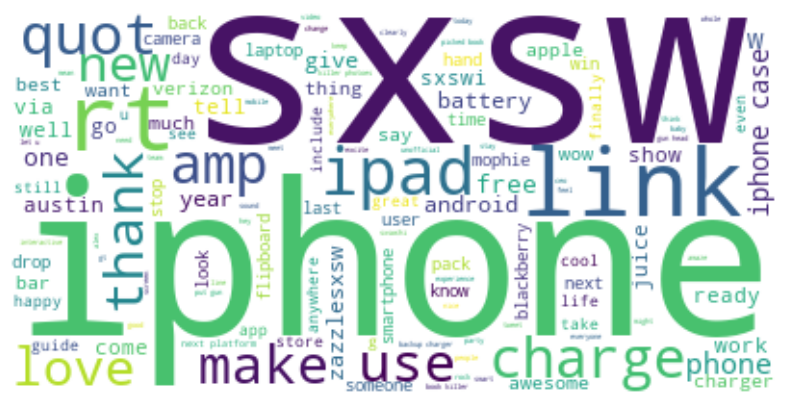

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df_iPhone_Positive['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


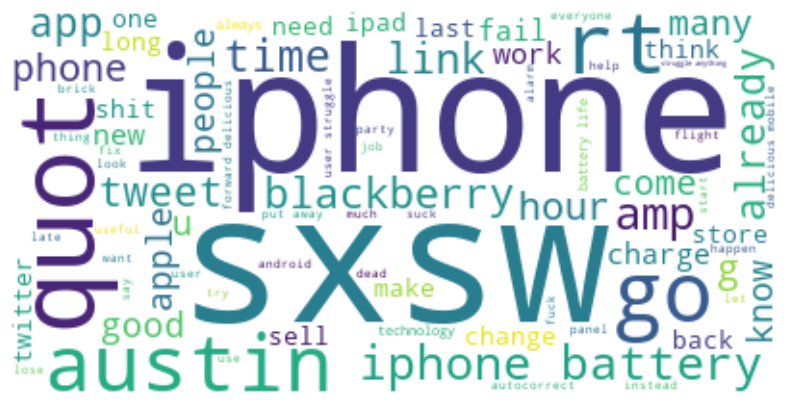

In [110]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df_iPhone_Negative['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

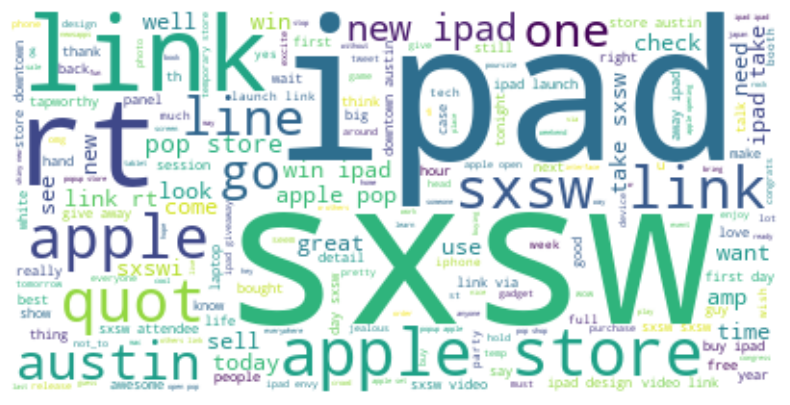

In [111]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df_iPad_Positive['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

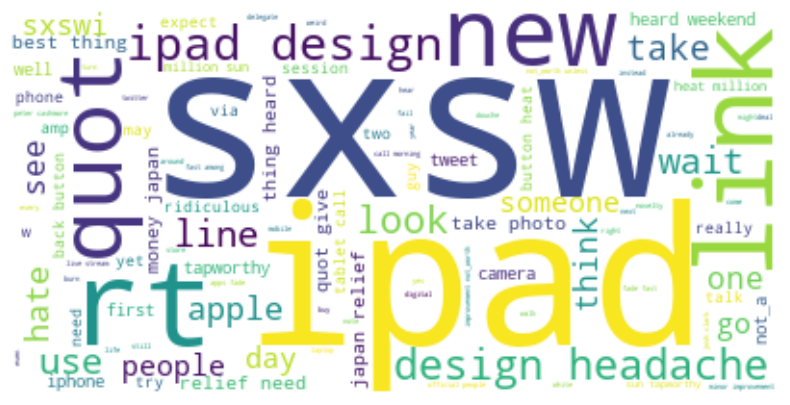

In [112]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df_iPad_Negative['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

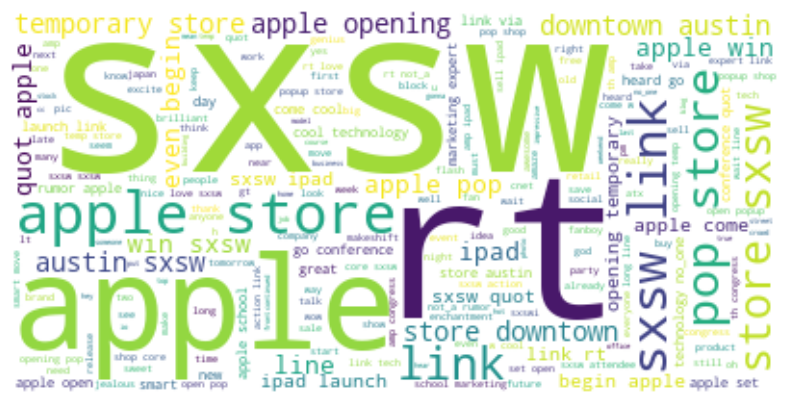

In [113]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df_Apple_Positive['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

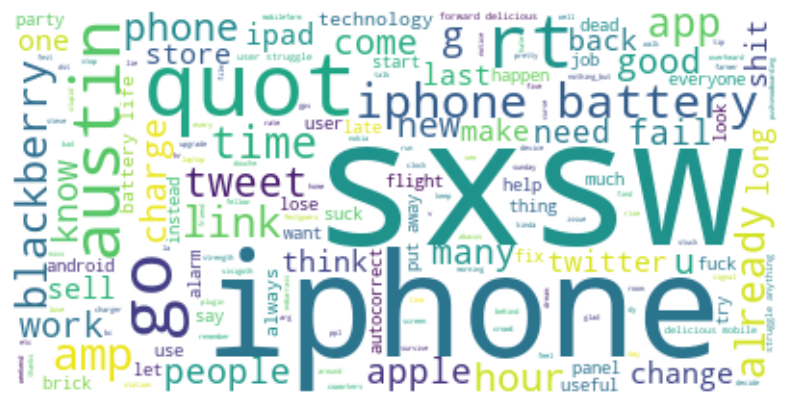

In [114]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df_iPhone_Negative['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

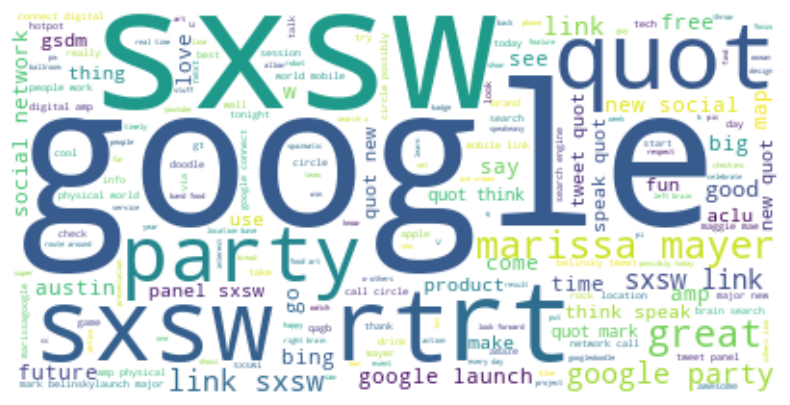

In [115]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df_Google_Positive['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

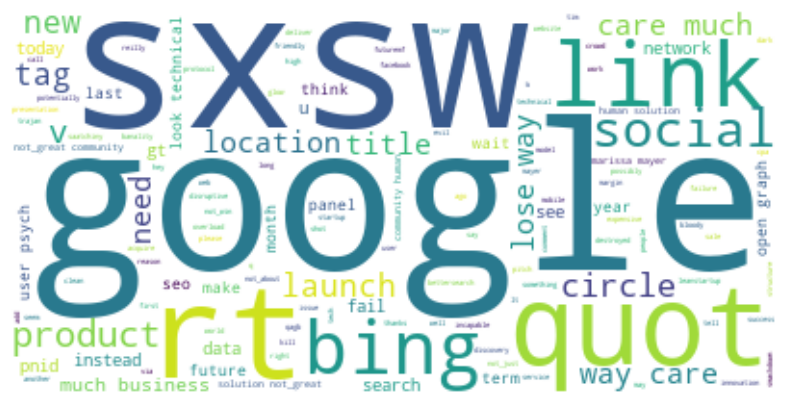

In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(tweet for tweet in df_Google_Negative['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

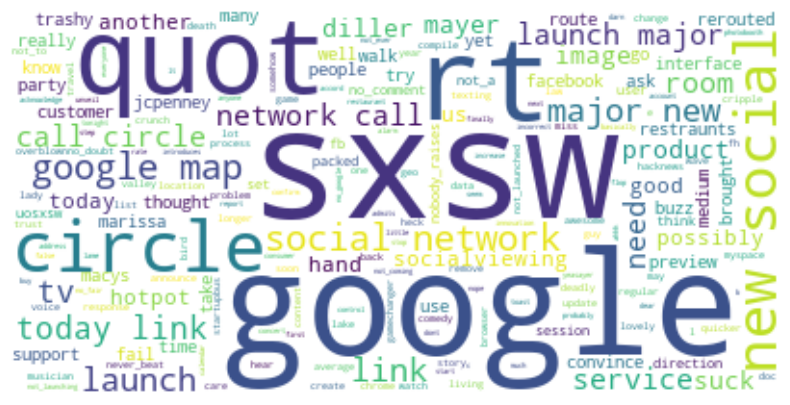

In [118]:

text = " ".join(tweet for tweet in df_Google_Apps_Negative['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

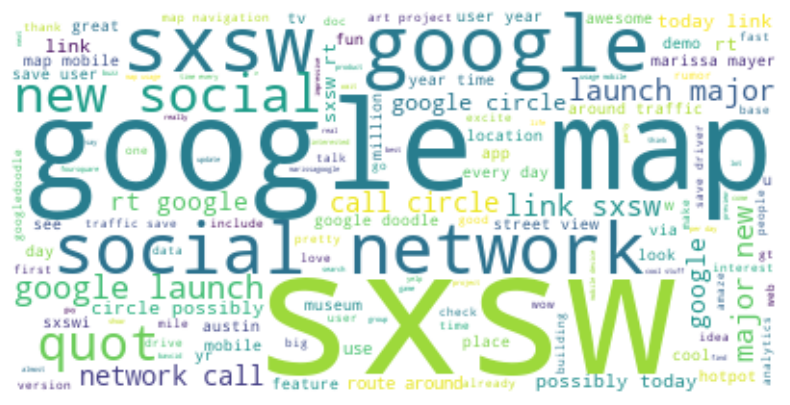

In [119]:
text = " ".join(tweet for tweet in df_Google_Apps_Positive['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [144]:
words = " ".join(df_Google_Apps_Positive['processed']).split()
word_count = Counter(words)

word_count_df = pd.DataFrame(word_count.items(), columns=['Word', 'Count'])
word_count_df.to_csv('word_count_Google_Positive.csv', index=False)

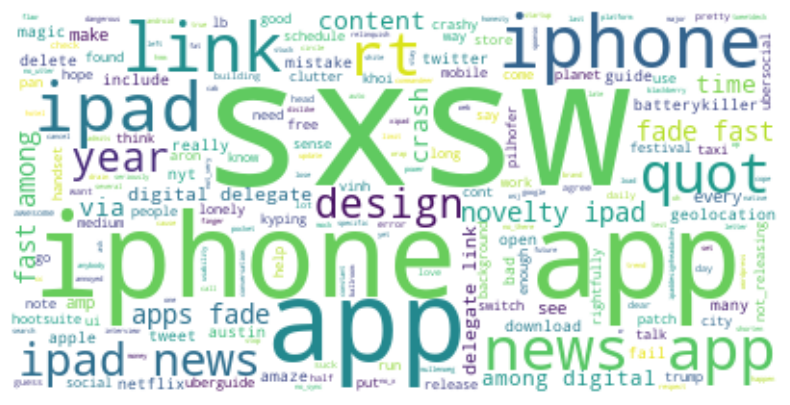

In [120]:
text = " ".join(tweet for tweet in df_Apple_Apps_Negative['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

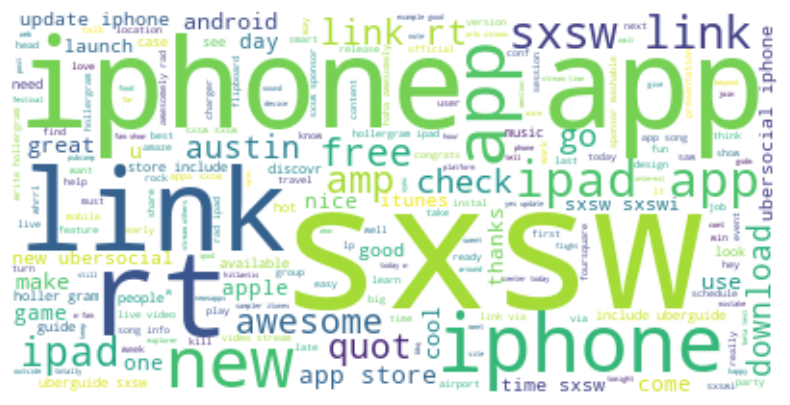

In [121]:
text = " ".join(tweet for tweet in df_Apple_Apps_Positive['processed'])

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [126]:
import spacy

nlp = spacy.load('en_core_web_sm')

sample_tweet = df_iPhone_Positive['processed'].iloc[0]  # Replace with a specific tweet if needed
doc = nlp(sample_tweet)

spacy.displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})
